# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import joblib

import import_ipynb

# Import data

In [2]:
import data_preprocessing

# load the data as formatted dataframe
data = data_preprocessing.Data(tags_or_genres='genres', min_label_occ=50)
print(data.games.head())

   game_id                                               name  \
0  1418860  Zaccaria Pinball - House of Diamonds Deluxe Pi...   
1  1418900                Sayonara Golden Days - Golden Souls   
2  1418980          Medieval Dynasty - Digital Supporter Pack   
3  1418990                              Unicorns on Unicycles   
4  1419040                         Road Maintenance Simulator   

                                         description  \
0  purchase this dlc disables score limit on this...   
1  the dlc will does not affect really affect the...   
2  the digital supporter pack of medieval dynasty...   
3  turn your horns into swords in this wacky and ...   
4  experience the everyday life in a german stree...   

                                              genres  
0  [Action,  Casual,  Free to Play,  Indie,  Simu...  
1                                            [Indie]  
2            [Action,  Adventure,  RPG,  Simulation]  
3                          [Action,  Casual,  Indie]

In [3]:
data.games['description'].shape

(50271,)

# Input preprocessing
Convert complex input (game description) into simple input for model  
Result input variable will be named `X`

We will be using [Sklearn library](https://scikit-learn.org/1.5/modules/feature_extraction.html) to perform the feature extraction

In [4]:
import input_preprocessing

X = input_preprocessing.bag_of_words(data.games['description'], max_features=10000)
# X = input_preprocessing.tfidf(data.games['description'], max_features=10000)
# X = input_preprocessing.hashing(data.games['description'], n_features=100)
X.shape

(50271, 10000)

# Output preprocessing
Convert complex output (game tags) into simple output for model (multi-label classification)  
Resulting output variable will be named `y`

In [5]:
import output_preprocessing

y = output_preprocessing.multilabel_binarizer(data.games['genres'])
y.shape

(50271, 40)

# Evaluation methods
We want to create function `evaluate(y_pred, y_true)` that will evaluate the model performance

In [6]:
import evaluation_methods

# evaluate = evaluation_methods.recall
evaluate = evaluation_methods.f1score

# Model
Use the given preprocessed input `X`, output `y`, evaluation functions `evaluate(y_pred, y_true)`, to train a chosen model (and save the model)  
Resulting model will be class named `Model` with methods:  
* fit(X, y) - train the model
* predict(X) - predict the output for given input
* save_model(path) - save the model to the given path
* load_model(path) - load the model from the given path
* evaluate() - evaluate the model performance

In [7]:
import models

# model = models.KNN(X, y, evaluate)
model = models.LogisticRegression(X, y, evaluate, max_iter=40)
# model = models.DecisionTree(X, y, evaluate)
# model = models.RandomForest(X, y, evaluate)
# model = models.NaiveBayes(X, y, evaluate)
# model = models.SVM(X, y, evaluate)
# model = models.MLP(X, y, evaluate)

# Model training and evaluation

In [8]:
model.fit()
print(model.evaluate())

score: 0.6040883458646616: 100%|██████████| 40/40 [02:23<00:00,  3.59s/it]


0.6040883458646616


# Data visualization
Play with the data, visualize model performance, etc.

## Input data

### PCA analysis

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1000)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

# print pca analysis
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)

# plot
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()


### t-SNE analysis

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 50271 samples in 0.054s...
[t-SNE] Computed neighbors for 50271 samples in 12.965s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50271
[t-SNE] Computed conditional probabilities for sample 2000 / 50271
[t-SNE] Computed conditional probabilities for sample 3000 / 50271
[t-SNE] Computed conditional probabilities for sample 4000 / 50271
[t-SNE] Computed conditional probabilities for sample 5000 / 50271
[t-SNE] Computed conditional probabilities for sample 6000 / 50271
[t-SNE] Computed conditional probabilities for sample 7000 / 50271
[t-SNE] Computed conditional probabilities for sample 8000 / 50271
[t-SNE] Computed conditional probabilities for sample 9000 / 50271
[t-SNE] Computed conditional probabilities for sample 10000 / 50271
[t-SNE] Computed conditional probabilities for sample 11000 / 50271
[t-SNE] Computed conditional probabilities for sample 12000 / 50271
[t-SNE] Computed conditional probabilities for s

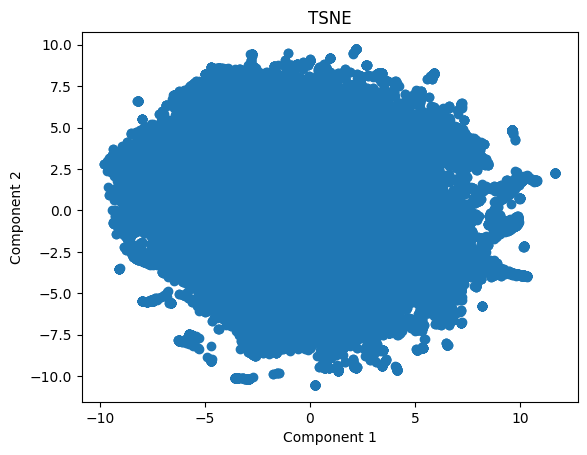

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, max_iter=300)
X_tsne = tsne.fit_transform(X_pca)
print(X_tsne.shape)

# plot
plt.figure()
plt.scatter(X_tsne[:,0], X_tsne[:,1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('TSNE')
plt.show()

## Model

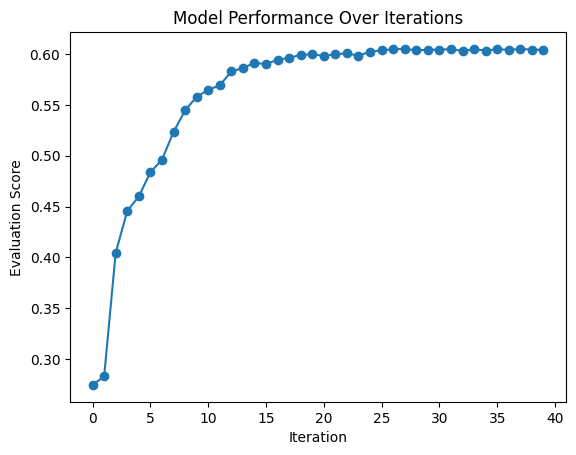

In [11]:
def plot_performance():
    plt.plot(model.history_, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Evaluation Score")
    plt.title("Model Performance Over Iterations")
    plt.show()

plot_performance()